In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
# from RKHS import SparseVFC
# from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import hotspot
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

import seaborn as sns
from scipy.stats import gaussian_kde

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())


2.3.0
None
False
0


In [2]:
pca_dim = 50
[k_nei, K, L] = [10, 3, 6]
    
# new_para_name = 'PCA'
# new_para_name = 'eigengene'
# new_para_name = 'eigengene_xiaohe'
# new_para_name = 'hotspot'
new_para_name = 'GE'
# new_para_name = ''


In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

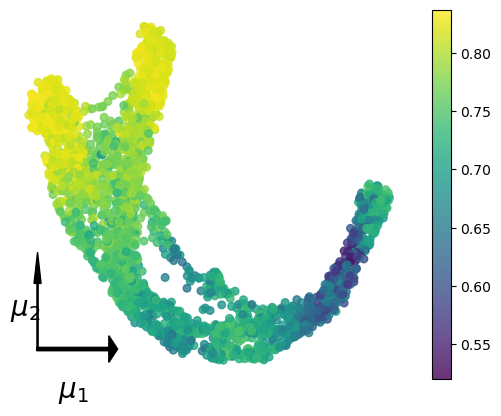

In [6]:
data_path='data/'

data_name = 'EG_ab_bin1.h5ad'

adata0=scv.read(data_path+data_name, cache=True)

model_name = 'EG_ab_bin1'

subfolder = 'Adjacency'

result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}/' +f'{new_para_name}_critical/'
import os
folder = os.path.exists(result_path)
if not folder:              
    os.makedirs(result_path)

###############读数据
read_path = 'results/'+model_name+'/'+f'{subfolder}/'+ f'k_nei={k_nei}/'
para = f'K={K} L={L}/'
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
cell_vpt=color_label
X=Xs

###读存储数据numpy版本导致clusters_mine_mine读取失败运行这段代码
np.load.__defaults__ =(None, True, True, 'ASCII')
clusters = np.load(read_path+'clusters'+'.npy')
clusters_PAGA = np.load(read_path+'clusters_PAGA'+'.npy')
# gene_arr = np.load(read_path+para+'gene_arr'+'.npy')
np.load.__defaults__ =(None, False, True, 'ASCII')

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def Fisher_dist_new(mu1, sigma1, mu2, sigma2):
    dmu = (mu1 - mu2) / np.sqrt(2)
    sigma_sum = sigma1 + sigma2
    sigma_diff = sigma1 - sigma2
    
    a = np.sqrt(dmu**2 + sigma_sum**2) + np.sqrt(dmu**2 + sigma_diff**2)
    b = np.sqrt(dmu**2 + sigma_sum**2) - np.sqrt(dmu**2 + sigma_diff**2)
    
    dF2 = 2 * np.sum(np.log(a / b)**2)
    return np.sqrt(dF2)

def wasserstein_distance_new(mu1, sigma1, mu2, sigma2):
    dmu = mu1 - mu2
    W_dist2 = np.sum(dmu**2 + sigma1**2 + sigma2**2 - 2 * np.sqrt(sigma2 * sigma1**2 * sigma2))
    return np.sqrt(W_dist2)

def Jacobian_nn_new(x0, encoder):
    x = torch.tensor(x0, requires_grad=True)
    
    # Compute the Jacobian for both outputs in the encoder
    z=encoder(x)

    jacobian = torch.autograd.functional.jacobian(z, x)
    
    # Split the jacobian into two parts
    d = jacobian.shape[0] // 2
    pMu_pX = jacobian[:d]
    pSgm_pX = jacobian[d:]
    
    return pMu_pX.numpy(), pSgm_pX.numpy()



###读存储数据
X_plt = np.load(read_path+'X_plt'+'.npy')
Y_plt = np.load(read_path+'Y_plt'+'.npy')
##坐标 和 伪时间图

X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min+5*wid
Y_ori = Y_min+5*wid

plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=crc_smooth,cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid*1.5,color='black',head_width=12*wid,head_length=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=4*wid,head_length=14*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*22,'$\mu_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')

# plt.savefig(result_path+model_name+'_mu.png',dpi=600,bbox_inches='tight')
plt.show()

In [7]:
#######要跑
adata=adata0.copy()
# velo0 = np.array(adata.layers['velocity'])
# velo_g = np.zeros(velo0.shape)
# velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
# velo_pca = velo_g@adata.varm['PCs']
# #latent_z = np.hstack((mu_learned,sigma_learned))

In [8]:
##
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

In [9]:
import sklearn
print(sklearn.__version__)

1.4.2


In [10]:
from utils import *
velo = np.load(read_path+'velocity'+'.npy')

In [11]:
##原始基因空间的导数，直接使用Gaussian embedding 的神经网络
if new_para_name == '':
    pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
    pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
    for i in range(X.shape[0]):
        pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)
        # pMu_pX[i],pSgm_pX[i] = Jacobian_nn_new(X[i],L,encoder)


In [ ]:
###gene FI and stiff gene
if new_para_name != 'GE':
    stiffnum = np.zeros(X.shape[0])##number of stiffgene |(n,1)
    # tf_stiffnum = np.zeros(X.shape[0])
    pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
    diagFIgene = np.zeros((X.shape[0],X.shape[1])) ##Fisher information of gene |(n,m)
    Eigenvec = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
    Eigenval = []  ##前2特征值 | (n,2)
    for i in range(X.shape[0]):
        pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
        FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
        Eigenval.append([np.linalg.eigh(FIgene_i)[0][-1],np.linalg.eigh(FIgene_i)[0][-2]])
        Eigenvec[i] = np.linalg.eigh(FIgene_i)[1][:,-1]
        diagFIgene[i] = np.diag(FIgene_i)
        FI_max = np.array([np.argmax(FIgene_i[j]) for j in range(X.shape[1])])
        # tf_max = np.array([np.argmax(FIgene_i[tf_inds][:,tf_inds][j]) for j in range(len(tf_inds))])
        stiffnum[i] = len(np.unique(list(FI_max)))
        # tf_stiffnum[i] = len(np.unique(list(tf_max)))
else:###在Gaussian embedding空间把embedding结果向量来做后续的聚类尝试一下
    n,L,_ = Fisher_g.shape
    L = L//2
    Eigenvec = np.zeros((n,L))
    for i in range(n):
        Eigenvec[i] = np.diag(Fisher_g[i])[:L]
        Eigenvec[i] = Eigenvec[i]/np.linalg.norm(Eigenvec[i])
    # Eigenvec = np.hstack((mu_learned,sigma_learned))
    # for i in range(n):
    #     Eigenvec[i] = Eigenvec[i]/np.linalg.norm(Eigenvec[i])


Eigen gene direction

In [13]:
clusters0 = clusters
clusters = adata.obs['clusters'] ##在这行是之后使用的细胞聚类方法，可以自行更换比如PAGA
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

In [14]:
for i in categories:
    print(i,len(Eigenvec[clusters==i]))

Alpha 477
Beta 591
Fev+ 587
Ngn3 high EP 529
Ngn3 low EP 138


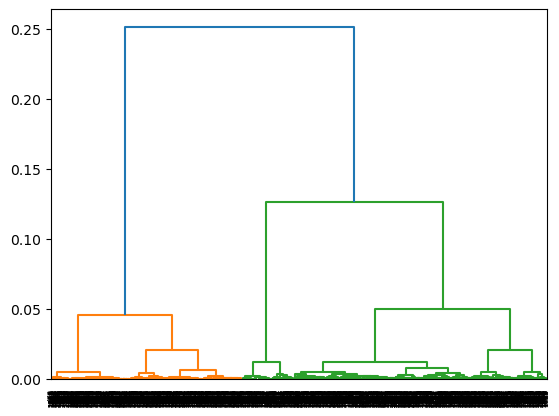

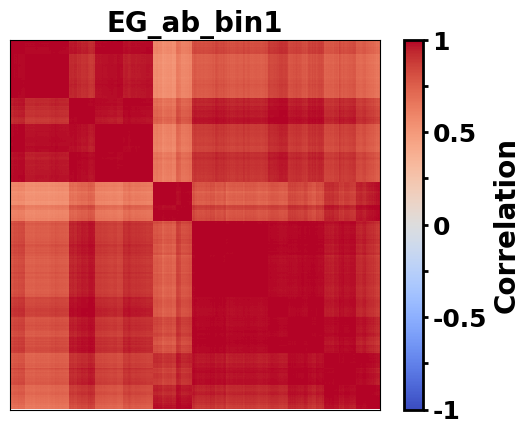

In [15]:
### 粗分类 
from matplotlib.colors import Normalize                

vec_corr = Eigenvec@Eigenvec.T
Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
#X_re= X[:,dg['leaves']]#X_re reorder X by clustering
plt.show()

vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest',norm=Normalize(-1,1))
plt.title(model_name,fontsize=20,weight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=12)
cb.ax.tick_params(width=2)  # 设置刻度线宽度
cb.outline.set_linewidth(2)  # 设置 colorbar 边框宽度
# 设置 colorbar 刻度字体和加粗
for tick in cb.ax.get_yticklabels():
    tick.set_fontsize(18)  # 设置刻度标签字体大小
    tick.set_weight('bold')  # 设置刻度标签加粗
# 设置 colorbar 的标题
cb.set_ticklabels(['-1','', '-0.5', '','0','', '0.5','', '1'])  # 设置刻度标签
cb.set_label('Correlation', fontsize=20, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.savefig(result_path+f'Corr_new of {model_name}.png')
plt.show()


In [16]:
#cluster threshold is t
# t = 1 - np.cos(np.pi/8)#threshold                    自行选择
# t = 1 - 1.97/2#threshold                    自行选择
# T = fcluster(Z, t=t, criterion='distance')

T = fcluster(Z, t=len(np.unique(clusters)), criterion='maxclust')
print(T)

[4 4 2 ... 5 4 4]


In [17]:
from collections import Counter

def my_Rearrange(arr):
    flat = arr.ravel()
    counter = Counter(flat)
    # 按出现次数从多到少排序，次数相同按元素大小排序
    sorted_items = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    # 构造数字到新编号的映射
    mapping = {num: i+1 for i, (num, _) in enumerate(sorted_items)}

    # 替换
    new_flat = np.array([mapping[x] for x in flat])
    new_arr = new_flat.reshape(arr.shape)
    return new_arr
T = my_Rearrange(T)
print(T)

[1 1 2 ... 4 1 1]


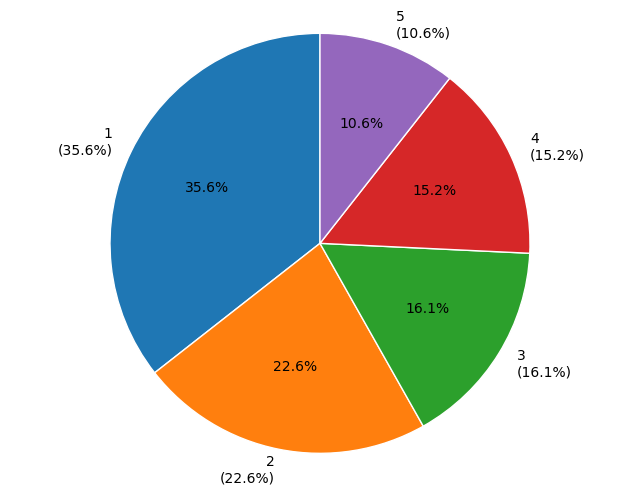

In [18]:
unique, counts = np.unique(T, return_counts=True)
total = len(T)

# 设置标签（显示元素值和百分比）
labels = [f'{val}\n({cnt/total:.1%})' for val, cnt in zip(unique, counts)]

# 绘制饼图
plt.figure(figsize=(8, 6))
plt.pie(counts, 
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor':'white'})

plt.title('', fontsize=15)
plt.axis('equal')
plt.show()


In [19]:
colors_hex = [
    "#FF5733", "#FFBD33", "#FFC300", "#DAFF33", "#33FF57", 
    "#33FFBD", "#33C1FF", "#337BFF", "#335BFF", "#5733FF", 
    "#BD33FF", "#FF33F6", "#FF33A1", "#FF335B", "#FF5733", 
    "#FF8D33", "#FF3333", "#FF6633", "#FF9933", "#FFFF33", 
    "#BFFF33", "#33FF8D", "#33FF99", "#33FFFF", "#3399FF", 
    "#3366FF", "#6633FF", "#9933FF", "#FF33C4", "#FF33A1", 
    "#FF5733", "#FF8D33"
]

# 转换为NumPy数组
colors_np = np.array(colors_hex)

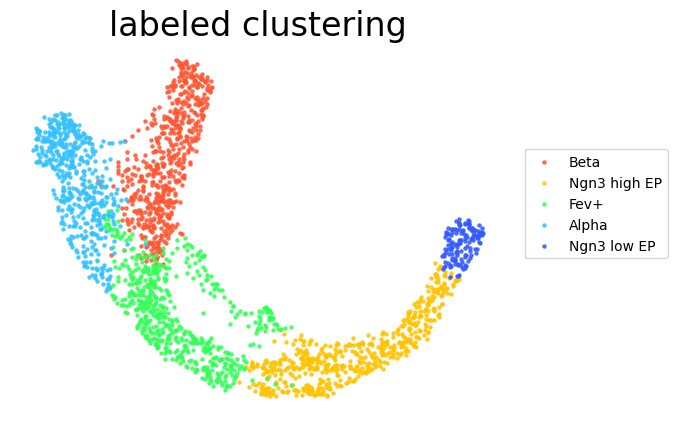

In [20]:
plt.figure()
for k,i in enumerate(set(clusters)):
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = colors_np[k*2],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.title('labeled clustering', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path+'cell_type.png',bbox_inches='tight')
plt.show()

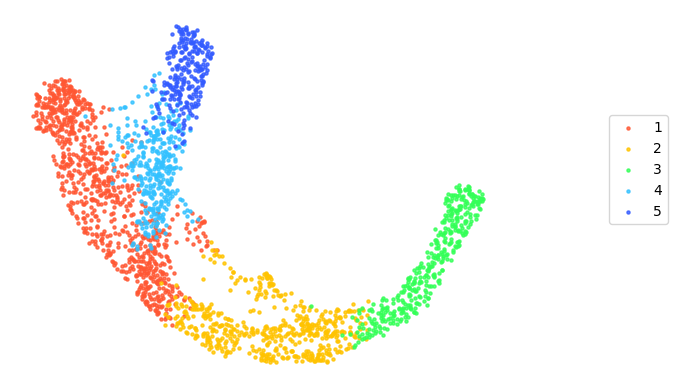

In [21]:
clusters_my_coarse = T.copy()
for k,i in enumerate(set(clusters_my_coarse)):
    plt.scatter(X_plt[clusters_my_coarse==i],Y_plt[clusters_my_coarse==i], s= 5,c = colors_np[k*2],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path+'clusters_mine_coarse.png',bbox_inches='tight')
plt.show()

In [297]:
clusters_fine = adata0.obs['clusters_fine']

## DTNE

In [22]:
X.shape

(2322, 514)

In [23]:
from dtne import *
dtne_operator = DTNE(k_neighbors = 10,l=2) 
Y = dtne_operator.fit_transform(X)

In [24]:
dtne_pseudotime = dtne_operator.order_cells(root_cells=[0])

In [25]:
dtne_cluster = dtne_operator.cluster_cells(n_clusters=5) ## 自行选择聚类数目 

In [26]:
# len(set(dtne_operator.cluster_cells(cluster_method = 'dbscan',eps=0.25))) ##dbscan,kmedoids,agglo

In [27]:
TT = {}

for i in categories:
    dtne_operator_small = DTNE(k_neighbors = 10,l=2) 
    Y = dtne_operator_small.fit_transform(X[clusters == i])
    T = dtne_operator_small.cluster_cells(cluster_method = 'dbscan',eps=0.25)
    TT[i] = T

In [28]:
dtne_cluster_fine = []
ktime = {}
for k,i in enumerate(clusters):
    if i in ktime:
        ktime[i] = ktime[i]+1
    else:
        ktime[i] = 0
    dtne_cluster_fine.append(f'{i}_{TT[i][ktime[i]]}')
dtne_cluster_fine = np.array(dtne_cluster_fine)
print(len(set(dtne_cluster_fine)))

14


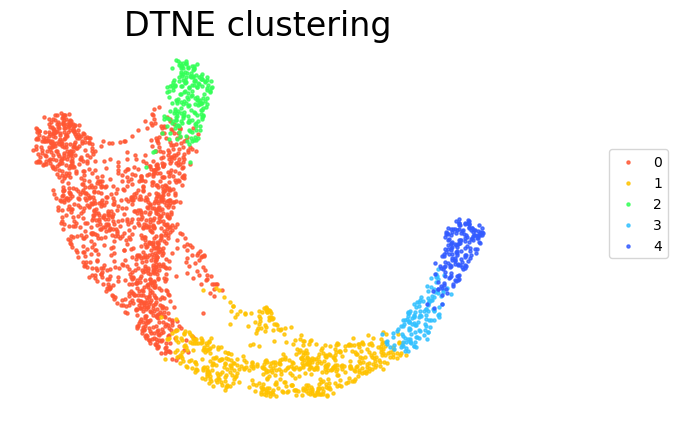

In [30]:
plt.figure()
for k,i in enumerate(set(dtne_cluster)):
    plt.scatter(X_plt[dtne_cluster==i],Y_plt[dtne_cluster==i], s= 5,c = colors_np[k*2],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.title('DTNE clustering', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path+'DTNE.png',bbox_inches='tight')
plt.show()

### clustering index

In [31]:
import multiscale_phate as mp
import scanpy as sc
from sklearn import metrics,cluster

In [32]:
mp_op = mp.Multiscale_PHATE(random_state=0,n_pca=10,n_jobs=-2)
levels = mp_op.fit(X)
tree_clusters = mp_op.get_tree_clusters(128)
print(len(set(tree_clusters)))
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 128)
tree_clusters = mp_op.get_tree_clusters(128)
len(set(mp_clusters))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculating diffusion potential...
  Calculated diffusion potential in 1.81 seconds.
  Setting epsilon to 2.9632
  Setting merge threshold to 0.1191
  Calculating condensation...
  Calculated condensation in 6.46 seconds.
Calculated Multiscale PHATE tree in 8.31 seconds.
Computing gradient...
Identifying salient levels of resolution...
13


13

In [33]:
def rank_sort(arr):
    b = list(np.unique(arr))
    rank = []
    for i in arr:
        rank.append(b.index(i))
    return rank

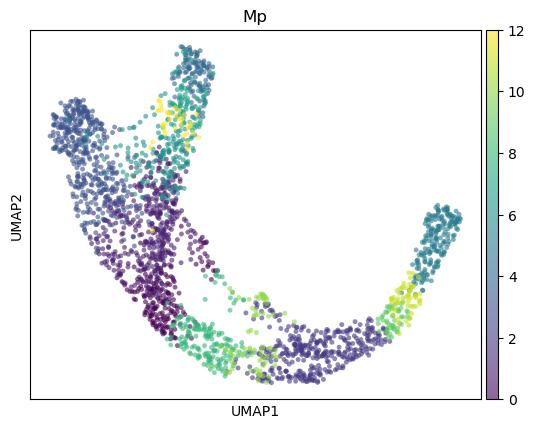

Multiscale PHATE: 0.42232354123638216 0.5980095392784878


In [34]:
adata.obs['Mp'] = rank_sort(mp_clusters)
sc.pl.umap(adata, color='Mp', s=50, alpha=0.6, ncols=3)
ari_mp = metrics.adjusted_rand_score(mp_clusters, clusters)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, clusters)
print("Multiscale PHATE:",ari_mp,ami_mp)

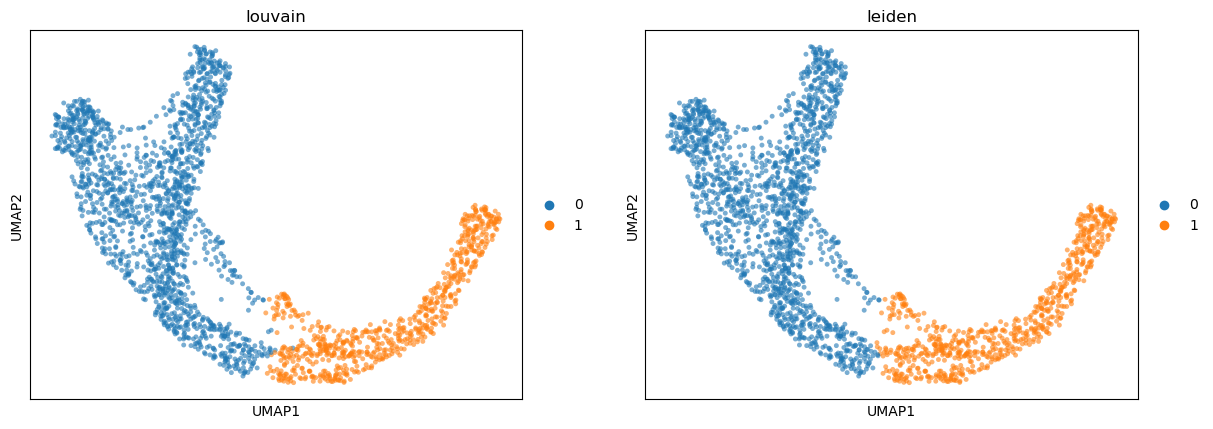

leiden: 0.3194503358705616 0.5043840808164028
louvain: 0.31210077989329527 0.490622949757798
my_coarse: 0.4200694235615765 0.5908401042021776


In [38]:

# sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.07, use_weights=True)
sc.tl.louvain(adata,resolution=0.07, use_weights=True)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=3)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, clusters)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, clusters)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, clusters)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, clusters)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

###dtne
ari_dtne = metrics.adjusted_rand_score(dtne_cluster, clusters)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, clusters)

ari_my_coarse = metrics.adjusted_rand_score(clusters_my_coarse, clusters)
ami_my_coarse = metrics.adjusted_mutual_info_score(clusters_my_coarse, clusters)

print("my_coarse:",ari_my_coarse,ami_my_coarse)

In [39]:
# from scipy.spatial.distance import pdist, squareform
# dist_matrix = squareform(pdist(np.hstack((mu_learned,sigma_learned)), Fisher_distz))

In [41]:
### ARI,Fscore and NMI
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def clustering_f1_score(true_labels, cluster_labels):
    """
    计算聚类结果的宏平均F1分数
    :param true_labels: 真实类别索引数组，如 [0,0,1,1,2,2]
    :param cluster_labels: 聚类结果索引数组，如 [1,1,0,0,2,2]
    :return: 宏平均F1分数
    """
    # 构建混淆矩阵并建立簇-类别映射
    cm = confusion_matrix(true_labels, cluster_labels)
    n_classes = cm.shape[0]
    n_clusters = cm.shape[1]
    
    # 匈牙利算法匹配（使用最大权重匹配）
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # 计算每个匹配类别的F1
    f1_scores = []
    for r, c in zip(row_ind, col_ind):
        if cm[r, c] == 0:
            continue  # 忽略空匹配
        precision = cm[r, c] / np.sum(cm[:, c])
        recall = cm[r, c] / np.sum(cm[r, :])
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        f1_scores.append(f1)
    
    # 宏平均F1
    return np.mean(f1_scores) if f1_scores else 0.0
def calculate_metrics(true_labels, pred_labels):
    """
    计算聚类评估指标 
    :param true_labels: 真实标签
    :param pred_labels: 预测标签
    :return: ARI, F-score, NMI 三个指标值
    """
    # 调整兰德指数(ARI)
    ari = metrics.adjusted_rand_score(true_labels, pred_labels)
    
    # F-score (需要标签映射)
    fscore = clustering_f1_score(true_labels, pred_labels)
    
    # 标准化互信息(NMI)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    
    return ari, fscore, nmi
clusters_my_coarse1 = np.array([str(i) for i in clusters_my_coarse])
print(('ARI','F1-socre','NMI'))

print(calculate_metrics(clusters,clusters_my_coarse1))  ##大于0.75

('ARI', 'F1-socre', 'NMI')
(0.4200694235615765, 0.5759565360232907, 0.5917693415228985)


In [42]:
dtne_cluster = np.array([str(i) for i in dtne_cluster])

In [44]:
print(('ARI','F1-socre','NMI'))
print(calculate_metrics(clusters,dtne_cluster))  ##大于0.75


('ARI', 'F1-socre', 'NMI')
(0.2903272579405671, 0.6557476838442212, 0.5364323446467701)


In [46]:
####内部评价聚类指标
#轮廓系数
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

for k,i in enumerate([clusters,clusters_my_coarse]):
    ch_score = calinski_harabasz_score(X, i)
    db_score = davies_bouldin_score(X,i)
    score = silhouette_score(X,i)
    print(['clusters','clusters_my_coarse'][k])
    print(f"SC Index: {score:.4f}")          ##轮廓系数SC大于0.5认为效果好，0.3-0.5可接受
    print(f"CH Index: {ch_score:.4f}")       ##CH大于其他方法10%认为更好
    print(f"DB Index: {db_score:.4f}")       ##DB小于0.5质量高，大于1则说明重叠严重##

clusters
SC Index: 0.1992
CH Index: 701.4106
DB Index: 1.1992
clusters_my_coarse
SC Index: 0.2525
CH Index: 1212.5982
DB Index: 1.3658


In [47]:
for k,i in enumerate([dtne_cluster,mp_clusters]):
    ch_score = calinski_harabasz_score(X, i)
    db_score = davies_bouldin_score(X,i)
    score = silhouette_score(X,i)
    print(['dtne','mp_clusters'][k])
    print(f"SC Index: {score:.4f}")          ##轮廓系数SC大于0.5认为效果好，0.3-0.5可接受
    print(f"CH Index: {ch_score:.4f}")       ##CH大于其他方法10%认为更好
    print(f"DB Index: {db_score:.4f}")       ##DB小于0.5质量高，大于1则说明重叠严重

dtne
SC Index: 0.4275
CH Index: 1402.1272
DB Index: 0.8552
mp_clusters
SC Index: 0.2018
CH Index: 1063.0552
DB Index: 1.2985


In [49]:
_,F1_my_coarse,_=calculate_metrics(clusters,clusters_my_coarse1)
_,F1_dtne,_=calculate_metrics(clusters,dtne_cluster)

leiden_group = [str(i) for i in leiden_group]
_,F1_leiden,_ = calculate_metrics(clusters,leiden_group)

louvain_group = [str(i) for i in louvain_group]
_,F1_louvain,_ = calculate_metrics(clusters,louvain_group)

mp_clusters = [str(i) for i in mp_clusters]
_,F1_mp,_ = calculate_metrics(clusters,mp_clusters)

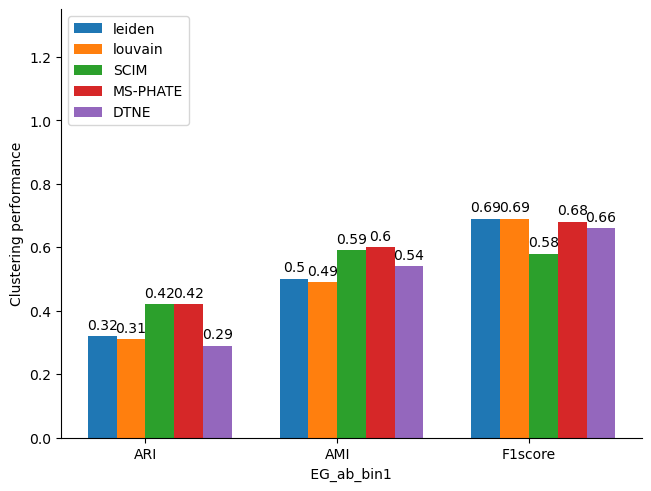

In [50]:
correlation = ['ARI','AMI','F1score']
pseudotime_corr = {
    'leiden':(round(ari_leiden,2), round(ami_leiden,2), round(F1_leiden,2)),
    'louvain':(round(ari_louvain,2), round(ami_louvain,2), round(F1_louvain,2)),
    'SCIM':(round(ari_my_coarse,2), round(ami_my_coarse,2), round(F1_my_coarse,2)),
    'MS-PHATE':(round(ari_mp,2), round(ami_mp,2), round(F1_mp,2)),
    'DTNE':(round(ari_dtne,2), round(ami_dtne,2), round(F1_dtne,2)),
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel(f'Clustering performance')
ax.set_xlabel(f' {model_name} ')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0,1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig(result_path+'EG.png', format='png', dpi=1000)
# plt.savefig('./Lake2018_plot.pdf', format='pdf', dpi=1000)